# Hyperparameters tuning for EffNetV2-S on Food101

The order of tuning hyperparameters maters, I will start from the most fundamental and general and finish with the ones that are much dependent on other hyperparameters, but before, I need to setup data for experiments, I will use 20% of full data. I don't have to rewrite code for LRFinder and train, I will import it from engine.py, they are exactly the same as I written them in the first notebook.

## Setup the data

In [1]:
import torch
import torchvision
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def create_effnet_v2s():
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    
    for p in model.features.parameters():
        p.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(1280, 101)
    ).to(device)
    
    return model

In [4]:
transform = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT.transforms()
transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [5]:
train_ds = ImageFolder("data/food101_20_percent/train", transform=transform)
valid_ds = ImageFolder("data/food101_20_percent/valid", transform=transform)

In [6]:
BATCH_SIZE = 32
num_workers = os.cpu_count() // 2 
num_workers

6

In [7]:
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=num_workers,
                      pin_memory=True)

## Optimizer

I will start from picking an optimizer, I will compare SGD with momentum and Adam, as far as I know SGD is better
in longer runs, therefore Adam will lose if they perform simillarly. *I also quickly tested SGD without momentum and RMSProp but they don't look promissing*

In [8]:
from engine import LRFinder, train

In [9]:
LRFinder?

Init signature: LRFinder(model, dataloader, loss_fn, optimizer)
Docstring:     
My implementation of learning rate finder for pytorch, based on https://docs.fast.ai/callback.schedule.html#lrfinder
Methods:
    LRFinder.find_lr()
    LRFinder.plot()
File:           ~/Desktop/pytorch-deep-learning/extras/exercises/engine.py
Type:           type
Subclasses:     

In [10]:
train?

Signature: train(model, train_dl, valid_dl, optimizer, loss_fn, epochs, writer=None)
Docstring: <no docstring>
File:      ~/Desktop/pytorch-deep-learning/extras/exercises/engine.py
Type:      function

First I will find optimal learning rates for both optimisers

In [11]:
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1, momentum=0.9)
lr_finder = LRFinder(model, train_dl, loss_fn, optimizer)
lr_finder.find_lr()

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Loss diverged, stopping early


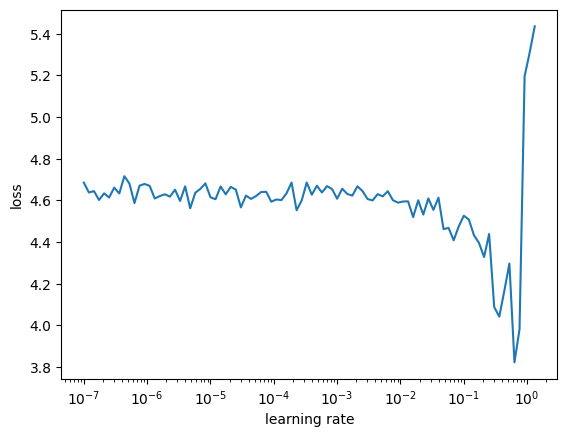

In [12]:
lr_finder.plot()

In [13]:
model = create_effnet_v2s()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1)
lr_finder = LRFinder(model, train_dl, loss_fn, optimizer)
lr_finder.find_lr()

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Loss diverged, stopping early


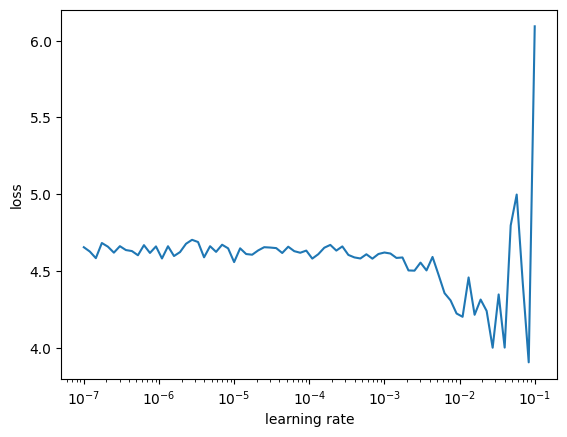

In [14]:
lr_finder.plot()

This time I will choose learning rates more carefully, first let's get an idea where should I search for the optimal value,
then I will search in this space more thoroughly

### SGD lr tuning

In [15]:
lr_rates = [0.5, 0.3, 0.1, 0.05, 0.01]

In [16]:
experiment_number = 0
for lr in lr_rates:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: SGD")
    print(f"[INFO] Learning rate: {lr}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.5


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.9291 | train_acc: 0.3080 | valid_loss: 2.7326 | valid_acc: 0.4653
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.3


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0963 | train_acc: 0.3273 | valid_loss: 2.1672 | valid_acc: 0.4859
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.1


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8882 | train_acc: 0.3383 | valid_loss: 2.1283 | valid_acc: 0.4889
--------------------------------------------------

[INFO] Experiment numer: 4
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.05


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1646 | train_acc: 0.3149 | valid_loss: 2.3954 | valid_acc: 0.4655
--------------------------------------------------

[INFO] Experiment numer: 5
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.01


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.0719 | train_acc: 0.2088 | valid_loss: 3.6439 | valid_acc: 0.3441
--------------------------------------------------



0.1 worked best, let's check values around it

In [17]:
lr_rates = [0.2, 0.09]

In [18]:
experiment_number = 0
for lr in lr_rates:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: SGD")
    print(f"[INFO] Learning rate: {lr}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.2


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8777 | train_acc: 0.3343 | valid_loss: 2.0321 | valid_acc: 0.4944
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.09


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9201 | train_acc: 0.3334 | valid_loss: 2.1154 | valid_acc: 0.4886
--------------------------------------------------



A final batch of learning rates to test for SGD:

In [19]:
lr_rates = [0.25, 0.15]

In [20]:
experiment_number = 0
for lr in lr_rates:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: SGD")
    print(f"[INFO] Learning rate: {lr}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.25


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9500 | train_acc: 0.3362 | valid_loss: 2.0859 | valid_acc: 0.4866
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: SGD
[INFO] Learning rate: 0.15


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8419 | train_acc: 0.3391 | valid_loss: 2.0166 | valid_acc: 0.5005
--------------------------------------------------



I will go with **0.15**

### Adam lr tuning

In [21]:
lr_rates = [0.05, 0.03, 0.01, 0.005, 0.001]

In [22]:
experiment_number = 0
for lr in lr_rates:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: Adam")
    print(f"[INFO] Learning rate: {lr}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.05


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 7.0441 | train_acc: 0.2779 | valid_loss: 5.0780 | valid_acc: 0.4415
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.03


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6802 | train_acc: 0.2872 | valid_loss: 3.2805 | valid_acc: 0.4533
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.01


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9552 | train_acc: 0.3292 | valid_loss: 2.1347 | valid_acc: 0.4799
--------------------------------------------------

[INFO] Experiment numer: 4
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.005


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9473 | train_acc: 0.3278 | valid_loss: 2.1244 | valid_acc: 0.4799
--------------------------------------------------

[INFO] Experiment numer: 5
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.001


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7053 | train_acc: 0.2535 | valid_loss: 3.1161 | valid_acc: 0.3913
--------------------------------------------------



In [25]:
lr_rates = [0.009, 0.008, 0.007, 0.006]

In [26]:
experiment_number = 0
for lr in lr_rates:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: Adam")
    print(f"[INFO] Learning rate: {lr}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=1)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.009


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9309 | train_acc: 0.3255 | valid_loss: 2.0810 | valid_acc: 0.4876
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.008


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9079 | train_acc: 0.3335 | valid_loss: 2.0808 | valid_acc: 0.4753
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.007


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8997 | train_acc: 0.3264 | valid_loss: 2.1079 | valid_acc: 0.4783
--------------------------------------------------

[INFO] Experiment numer: 4
[INFO] Optimizer: Adam
[INFO] Learning rate: 0.006


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9075 | train_acc: 0.3318 | valid_loss: 2.0946 | valid_acc: 0.4812
--------------------------------------------------



0.008, 0.007 and 0.006 perform similarly, I will go with **0.007**

### SGD vs Adam

In [30]:
optimizers = ["SGD", "Adam"]
experiment_number = 0
for optimizer in optimizers:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Optimizer: {optimizer}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()

    if optimizer == "Adam":
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.007)
    else:
        optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=10)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Optimizer: SGD


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3608 | train_acc: 0.2857 | valid_loss: 2.2905 | valid_acc: 0.4581


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1843 | train_acc: 0.4651 | valid_loss: 2.0675 | valid_acc: 0.4874


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9782 | train_acc: 0.5042 | valid_loss: 2.0708 | valid_acc: 0.5010


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.8435 | train_acc: 0.5338 | valid_loss: 2.1277 | valid_acc: 0.5027


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.7366 | train_acc: 0.5674 | valid_loss: 2.0941 | valid_acc: 0.5086


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.6416 | train_acc: 0.5789 | valid_loss: 2.0842 | valid_acc: 0.5135


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.5327 | train_acc: 0.6075 | valid_loss: 2.0418 | valid_acc: 0.5220


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.4125 | train_acc: 0.6280 | valid_loss: 2.0175 | valid_acc: 0.5307


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.2791 | train_acc: 0.6565 | valid_loss: 1.9555 | valid_acc: 0.5406


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.1479 | train_acc: 0.6876 | valid_loss: 1.9462 | valid_acc: 0.5416
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Optimizer: Adam


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7921 | train_acc: 0.2353 | valid_loss: 2.7259 | valid_acc: 0.4032


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.3467 | train_acc: 0.4459 | valid_loss: 2.1251 | valid_acc: 0.4737


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.1106 | train_acc: 0.4888 | valid_loss: 2.2503 | valid_acc: 0.4748


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 2.0618 | train_acc: 0.5085 | valid_loss: 2.2475 | valid_acc: 0.4899


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.9125 | train_acc: 0.5391 | valid_loss: 2.2587 | valid_acc: 0.4982


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.7294 | train_acc: 0.5741 | valid_loss: 2.2219 | valid_acc: 0.5087


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.5346 | train_acc: 0.6043 | valid_loss: 2.1281 | valid_acc: 0.5144


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.3425 | train_acc: 0.6438 | valid_loss: 2.0721 | valid_acc: 0.5279


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 1.2108 | train_acc: 0.6703 | valid_loss: 2.0331 | valid_acc: 0.5369


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 1.1545 | train_acc: 0.6856 | valid_loss: 2.0639 | valid_acc: 0.5253
--------------------------------------------------



That was a close one, anyways SGD won (lr=0.15, momentum=0.9)

## Data augmentation

In [14]:
from torchvision.transforms import v2

In [10]:
transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
transform_aug = v2.Compose([
    v2.TrivialAugmentWide(),
    v2.Resize((384, 384)),
    v2.PILToTensor(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

I will relay on TrivialAugmentWide as it is proven to work very well on image classification without any hyperparameter tuning. *I also tested RandomAugment on several magnitude values, however as expected it performed similarly (but a little worse), I just think that it is not worth to spend time on tuning it if there is a simpler and faster way to achieve just as good or better results and therefore I deleted this experiment*

In [12]:
transforms = [transform, transform_aug]
experiment_number = 0
for transf in transforms:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    if experiment_number == 1:
        print(f"[INFO] transform: no augmentation")
    else:
        print(f"[INFO] transform: TrivialAugmentWide")
        
    train_ds = ImageFolder("data/food101_20_percent/train", transform=transf)
    train_dl = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True)
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9)
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=5)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] transform: no augmentation


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1614 | train_acc: 0.2968 | valid_loss: 2.2200 | valid_acc: 0.4537


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1533 | train_acc: 0.4752 | valid_loss: 2.0995 | valid_acc: 0.4926


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.8981 | train_acc: 0.5289 | valid_loss: 2.0165 | valid_acc: 0.5136


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.6359 | train_acc: 0.5802 | valid_loss: 1.9512 | valid_acc: 0.5261


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.3741 | train_acc: 0.6384 | valid_loss: 1.8765 | valid_acc: 0.5384
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] transform: TrivialAugmentWide


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1911 | train_acc: 0.3091 | valid_loss: 2.0082 | valid_acc: 0.4902


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1302 | train_acc: 0.4830 | valid_loss: 1.8604 | valid_acc: 0.5284


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9193 | train_acc: 0.5267 | valid_loss: 1.8170 | valid_acc: 0.5408


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.7406 | train_acc: 0.5594 | valid_loss: 1.7314 | valid_acc: 0.5633


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.5381 | train_acc: 0.6046 | valid_loss: 1.7014 | valid_acc: 0.5723
--------------------------------------------------



Nice, it clearly makes a difference

In [12]:
train_ds = ImageFolder("data/food101_20_percent/train", transform=transform_aug)
train_dl = DataLoader(train_ds,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=True)

## Batch Size

Batch size 32 works out pretty well - it doesn't seem to negatively impact training and it utilizes 100% of my GPU, first I will check if reducing it to 16 or increasing to 64 makes any noticable improvement

In [15]:
from torch.utils.tensorboard.writer import SummaryWriter

- learning rate needs to be linearly scaled, as batch size is correl;ated with training stability
- epochs need to be linearly scaled to maintain constant amount of training steps

In [19]:
batch_sizes = [(16, 0.15/2), (32, 0.15), (64, 0.15*2)]
experiment_number = 0
for batch_sz, lr in batch_sizes:
    experiment_number += 1
    epochs = 2 ** experiment_number
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Batch size: {batch_sz}")
    print(f"[INFO] Learning rate: {lr}")
    print(f"[INFO] Epochs: {epochs}")
        
    train_dl = DataLoader(train_ds,
                          batch_size=batch_sz,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=True)
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=0.9)

    writer = SummaryWriter(log_dir=f"tensorboard_stats/batch_sizes_comparison/{batch_sz}")
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=epochs, writer=writer)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Batch size: 16
[INFO] Learning rate: 0.075
[INFO] Epochs: 2


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/947 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0572 | train_acc: 0.3091 | valid_loss: 1.9381 | valid_acc: 0.5145


Training:   0%|          | 0/947 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.0899 | train_acc: 0.4852 | valid_loss: 1.7987 | valid_acc: 0.5462
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Batch size: 32
[INFO] Learning rate: 0.15
[INFO] Epochs: 4


Epochs:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1245 | train_acc: 0.3109 | valid_loss: 1.9931 | valid_acc: 0.4991


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1165 | train_acc: 0.4781 | valid_loss: 1.8346 | valid_acc: 0.5382


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.8743 | train_acc: 0.5347 | valid_loss: 1.7718 | valid_acc: 0.5539


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.6252 | train_acc: 0.5897 | valid_loss: 1.7257 | valid_acc: 0.5605
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Batch size: 64
[INFO] Learning rate: 0.3
[INFO] Epochs: 8


Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2997 | train_acc: 0.3068 | valid_loss: 2.0605 | valid_acc: 0.4903


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.0808 | train_acc: 0.4941 | valid_loss: 1.8368 | valid_acc: 0.5379


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.8937 | train_acc: 0.5271 | valid_loss: 1.8082 | valid_acc: 0.5517


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.7639 | train_acc: 0.5572 | valid_loss: 1.7956 | valid_acc: 0.5588


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.6615 | train_acc: 0.5786 | valid_loss: 1.7842 | valid_acc: 0.5554


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 1.5419 | train_acc: 0.6037 | valid_loss: 1.7604 | valid_acc: 0.5657


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 1.4208 | train_acc: 0.6300 | valid_loss: 1.7016 | valid_acc: 0.5766


Training:   0%|          | 0/237 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 1.3154 | train_acc: 0.6523 | valid_loss: 1.6953 | valid_acc: 0.5734
--------------------------------------------------



Batch size 16 yields much worse results, batch size 64 seems to foster overfitting. I will keep batch size at 32.

## Weight Decay

And here comes the last hyperparameter I am going to test

In [39]:
train_dl = DataLoader(train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=num_workers,
                      pin_memory=True)

In [40]:
weight_decays = [0.01, 0.001, 1e-4, 1e-5]
experiment_number = 0
for wd in weight_decays:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Weight decay: {wd}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=wd)

    writer = SummaryWriter(log_dir=f"tensorboard_stats/weight_decay_search/{wd}")
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=5, writer=writer)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Weight decay: 0.01


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4562 | train_acc: 0.2857 | valid_loss: 2.6737 | valid_acc: 0.4118


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.9850 | train_acc: 0.3475 | valid_loss: 2.6808 | valid_acc: 0.4125


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.9636 | train_acc: 0.3497 | valid_loss: 2.6585 | valid_acc: 0.4168


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 2.9033 | train_acc: 0.3823 | valid_loss: 2.5859 | valid_acc: 0.4579


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 2.7578 | train_acc: 0.4578 | valid_loss: 2.6173 | valid_acc: 0.4778
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Weight decay: 0.001


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2045 | train_acc: 0.3157 | valid_loss: 2.0437 | valid_acc: 0.4983


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.2365 | train_acc: 0.4619 | valid_loss: 1.9261 | valid_acc: 0.5176


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.0461 | train_acc: 0.5030 | valid_loss: 1.8563 | valid_acc: 0.5346


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.9242 | train_acc: 0.5277 | valid_loss: 1.7919 | valid_acc: 0.5543


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.7343 | train_acc: 0.5753 | valid_loss: 1.7402 | valid_acc: 0.5642
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Weight decay: 0.0001


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1950 | train_acc: 0.3070 | valid_loss: 2.0441 | valid_acc: 0.4927


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1544 | train_acc: 0.4760 | valid_loss: 1.8583 | valid_acc: 0.5296


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9262 | train_acc: 0.5212 | valid_loss: 1.7969 | valid_acc: 0.5498


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.7451 | train_acc: 0.5575 | valid_loss: 1.7249 | valid_acc: 0.5676


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.5331 | train_acc: 0.6020 | valid_loss: 1.6949 | valid_acc: 0.5732
--------------------------------------------------

[INFO] Experiment numer: 4
[INFO] Weight decay: 1e-05


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1798 | train_acc: 0.3094 | valid_loss: 2.0304 | valid_acc: 0.4871


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1426 | train_acc: 0.4761 | valid_loss: 1.8523 | valid_acc: 0.5370


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9375 | train_acc: 0.5218 | valid_loss: 1.8135 | valid_acc: 0.5474


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.7268 | train_acc: 0.5626 | valid_loss: 1.7192 | valid_acc: 0.5679


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.5397 | train_acc: 0.6053 | valid_loss: 1.7036 | valid_acc: 0.5732
--------------------------------------------------



Now let's narrow the search space

In [41]:
weight_decays = [8e-4, 7e-4, 6e-4, 5e-4, 3e-4]
experiment_number = 0
for wd in weight_decays:
    experiment_number += 1
    print(f"[INFO] Experiment numer: {experiment_number}")
    print(f"[INFO] Weight decay: {wd}")
    
    model = create_effnet_v2s()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.15, momentum=0.9, weight_decay=wd)

    writer = SummaryWriter(log_dir=f"tensorboard_stats/weight_decay_search/{wd}")
        
    train(model, train_dl, valid_dl, optimizer, loss_fn, epochs=5, writer=writer)
        
    print("-"*50 + '\n')

[INFO] Experiment numer: 1
[INFO] Weight decay: 0.0008


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1944 | train_acc: 0.3137 | valid_loss: 2.0602 | valid_acc: 0.4917


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1964 | train_acc: 0.4708 | valid_loss: 1.8737 | valid_acc: 0.5212


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.0249 | train_acc: 0.4974 | valid_loss: 1.8312 | valid_acc: 0.5368


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.8723 | train_acc: 0.5341 | valid_loss: 1.7549 | valid_acc: 0.5535


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.6973 | train_acc: 0.5827 | valid_loss: 1.7310 | valid_acc: 0.5646
--------------------------------------------------

[INFO] Experiment numer: 2
[INFO] Weight decay: 0.0007


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1851 | train_acc: 0.3122 | valid_loss: 2.0607 | valid_acc: 0.4853


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1991 | train_acc: 0.4641 | valid_loss: 1.8433 | valid_acc: 0.5383


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.0042 | train_acc: 0.5047 | valid_loss: 1.8442 | valid_acc: 0.5440


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.8523 | train_acc: 0.5400 | valid_loss: 1.7440 | valid_acc: 0.5638


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.6665 | train_acc: 0.5904 | valid_loss: 1.7158 | valid_acc: 0.5692
--------------------------------------------------

[INFO] Experiment numer: 3
[INFO] Weight decay: 0.0006


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1987 | train_acc: 0.3090 | valid_loss: 2.0480 | valid_acc: 0.4899


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1647 | train_acc: 0.4711 | valid_loss: 1.8751 | valid_acc: 0.5270


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.0009 | train_acc: 0.5002 | valid_loss: 1.8270 | valid_acc: 0.5376


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.8285 | train_acc: 0.5456 | valid_loss: 1.7517 | valid_acc: 0.5519


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.6317 | train_acc: 0.5921 | valid_loss: 1.7015 | valid_acc: 0.5707
--------------------------------------------------

[INFO] Experiment numer: 4
[INFO] Weight decay: 0.0005


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1981 | train_acc: 0.3115 | valid_loss: 2.0206 | valid_acc: 0.4988


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1678 | train_acc: 0.4719 | valid_loss: 1.8559 | valid_acc: 0.5311


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9864 | train_acc: 0.5148 | valid_loss: 1.8164 | valid_acc: 0.5454


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.8117 | train_acc: 0.5487 | valid_loss: 1.7295 | valid_acc: 0.5572


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.6233 | train_acc: 0.5931 | valid_loss: 1.7073 | valid_acc: 0.5657
--------------------------------------------------

[INFO] Experiment numer: 5
[INFO] Weight decay: 0.0003


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1835 | train_acc: 0.3135 | valid_loss: 2.0361 | valid_acc: 0.4931


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.1644 | train_acc: 0.4738 | valid_loss: 1.8479 | valid_acc: 0.5347


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 1.9518 | train_acc: 0.5194 | valid_loss: 1.8179 | valid_acc: 0.5380


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.7723 | train_acc: 0.5492 | valid_loss: 1.7182 | valid_acc: 0.5663


Training:   0%|          | 0/474 [00:00<?, ?it/s]

Validation:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 1.5764 | train_acc: 0.5973 | valid_loss: 1.6896 | valid_acc: 0.5750
--------------------------------------------------



I choose weight decay = **7e-4**

### Weight decay scaling

From [AdamW paper](https://arxiv.org/abs/1711.05101) I know the following scaling formula:

$$ 
w = w_{norm} \sqrt{\frac{b}{BT}}
$$

- $w_{norm}$ - weight decay if only one batch pass is allowed
- b - batch size
- B - training points per epoch
- T - number of epochs

In the final training these stats are following:
- $b_{final} = b$
- $B_{final} = 5B$
- $T_{final} = 5T$ (25)

Therefore the final weight decay is:
$$ 
w_{final} = \frac{7e-4}{\sqrt{5*5}} = 1.4e-4
$$